In [79]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import random

import tarfile
import io
import os
import pandas as pd

from torch.utils.data import Dataset
import torch


class YourDataset(Dataset):
    def __init__(self, txt_path='filelist.txt', img_dir='data', testdata=False, transform=None):
        """
        Initialize data set as a list of IDs corresponding to each item of data set

        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        :param transform: apply some transforms like cropping, rotating, etc on input image
        """

        df = pd.read_csv(txt_path)
        self.img_names = df.Image.values
        self.testdata = testdata
        if not self.testdata:
            self.target = df.Class.values
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform
        self.to_tensor = ToTensor()
        self.to_pil = ToPILImage()
        self.get_image_selector = True if img_dir.__contains__('tar') else False
        self.tf = tarfile.open(self.img_dir) if self.get_image_selector else None

    def get_image_from_tar(self, name):
        """
        Gets a image by a name gathered from file list csv file

        :param name: name of targeted image
        :return: a PIL image
        """
        image = self.tf.extractfile(name)
        image = image.read()
        image = Image.open(io.BytesIO(image))
        return image

    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file

        :param name: name of targeted image
        :return: a PIL image
        """

        image = Image.open(os.path.join(self.img_dir, name))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs

        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set.

        :param index: index of item in IDs list

        :return: a sample of data as a dict
        """

        if index == (self.__len__() - 1) and self.get_image_selector:  # close tarfile opened in __init__
            self.tf.close()

        if self.get_image_selector:  # note: we prefer to extract then process!
            X = self.get_image_from_tar(self.img_names[index])
        else:
            X = self.get_image_from_folder(self.img_names[index])
            
            if not self.testdata:
                Y = self.target[index]

        if self.transform is not None:
            X = self.transform(X)

        if not self.testdata:
            sample = {'X': X,
                      'Y': Y}
        if self.testdata:
            sample = {'X': X}

        return sample

In [80]:
train = YourDataset(txt_path='../dataset/train.csv', img_dir='../dataset/train_images/1/')

In [81]:
test = YourDataset(txt_path='../dataset/test.csv', img_dir='../dataset/test_images/1/', testdata=True)

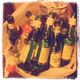

In [83]:
test[0]['X']